In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("suraj520/customer-support-ticket-dataset")

print("Path to dataset files:", path)

/opt/anaconda3/envs/my_python_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/danieljanini/.cache/kagglehub/datasets/suraj520/customer-support-ticket-dataset/versions/1


In [4]:
import pandas as pd
import numpy as np 
datapath = path + '/customer_support_tickets.csv'
data = pd.read_csv(datapath)

In [6]:
data.head(3)

,Ticket ID,Customer Name,Customer Email,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating
0,1,Marisa Obrien,carrollallison@example.com,32,Other,GoPro Hero,2021-03-22,Technical issue,Product setup,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Social media,2023-06-01 12:15:36,NaN,NaN
1,2,Jessica Rios,clarkeashley@example.com,42,Female,LG Smart TV,2021-05-22,Technical issue,Peripheral compatibility,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Chat,2023-06-01 16:45:38,NaN,NaN
2,3,Christopher Robbins,gonzalestracy@example.com,48,Other,Dell XPS,2020-07-14,Technical issue,Network problem,I'm facing a problem with my {product_purchase...,Closed,Case maybe show recently my computer follow.,Low,Social media,2023-06-01 11:14:38,2023-06-01 18:05:38,3.0


In [8]:
set(data["Ticket Type"])

{'Billing inquiry',
 'Cancellation request',
 'Product inquiry',
 'Refund request',
 'Technical issue'}

In [77]:
data["Ticket Description"].str.len().describe()

count    8469.000000
mean      289.821939
std        43.593954
min       151.000000
25%       273.000000
50%       298.000000
75%       318.000000
max       397.000000
Name: Ticket Description, dtype: float64

In [118]:
import re
import string
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(f"[{re.escape(string.punctuation)}]", '', text)
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text
    
data["Ticket Description"] = data["Ticket Description"].apply(clean_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/danieljanini/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Tokenization of the ticket descriptions

In [120]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import utils

## Splitting into training and testing

In [122]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(
    data["Ticket Description"], data["Ticket Type"], test_size=0.33, random_state=42)

In [128]:
# Encode the labels
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Encode string labels into integers
label_encoder = LabelEncoder()
train_y_encoded = label_encoder.fit_transform(train_y)
test_y_encoded = label_encoder.transform(test_y)

# One-hot encode
train_y_cat = to_categorical(train_y_encoded)
test_y_cat = to_categorical(test_y_encoded)


## Train a Neural Net 

In [183]:
import tensorflow_hub as hub

# Load the pre-trained embedding layer
hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim50/2", 
                           input_shape=[], dtype=tf.string, trainable=False)

# Use the Functional API
input_text = tf.keras.Input(shape=(), dtype=tf.string, name='text')
x = hub_layer(input_text)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
output = tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')(x)

model = tf.keras.Model(inputs=input_text, outputs=output)

# Compile
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


TypeError: Exception encountered when calling layer 'keras_layer_1' (type KerasLayer).

Binding inputs to tf.function failed due to `A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.ops`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```
`. Received args: (<KerasTensor shape=(None,), dtype=string, sparse=False, ragged=False, name=text>,) and kwargs: {} for signature: (sentences: TensorSpec(shape=(None,), dtype=tf.string, name=None)).

Call arguments received by layer 'keras_layer_1' (type KerasLayer):
  • inputs=<KerasTensor shape=(None,), dtype=string, sparse=False, ragged=False, name=text>
  • training=None

In [181]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense

model = tf.keras.Sequential([
    embedding_layer,
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

ValueError: Only instances of `keras.Layer` can be added to a Sequential model. Received: <tensorflow_hub.keras_layer.KerasLayer object at 0x31aedec60> (of type <class 'tensorflow_hub.keras_layer.KerasLayer'>)

In [167]:
history = model.fit(train_padded, train_y_cat,
          validation_data=(test_padded, test_y_cat),
          epochs=10,
          batch_size=32)

Epoch 1/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.1975 - loss: 1.6137 - val_accuracy: 0.1939 - val_loss: 1.6110
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.2018 - loss: 1.6100 - val_accuracy: 0.2043 - val_loss: 1.6114
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.1930 - loss: 1.6107 - val_accuracy: 0.1979 - val_loss: 1.6132
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.2122 - loss: 1.6081 - val_accuracy: 0.2011 - val_loss: 1.6115
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.2100 - loss: 1.6072 - val_accuracy: 0.2039 - val_loss: 1.6104
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.2150 - loss: 1.6080 - val_accuracy: 0.2011 - val_loss: 1.6130
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.2135 - loss: 1.6067 - val_accuracy: 0.1989 - val_loss: 1.6108
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.2149 - loss: 1.6063 - val_accu

## Plotting results

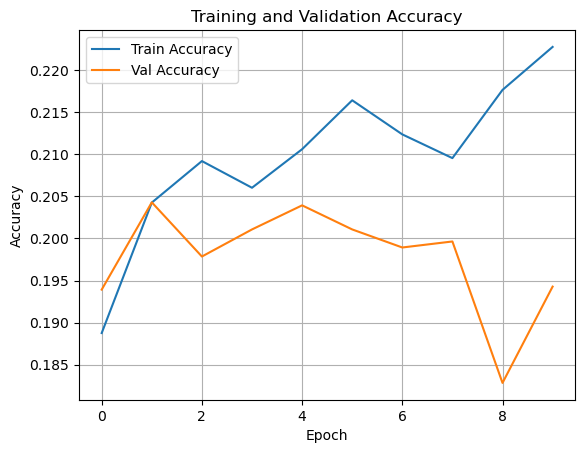

In [169]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.grid(True)
plt.show()


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


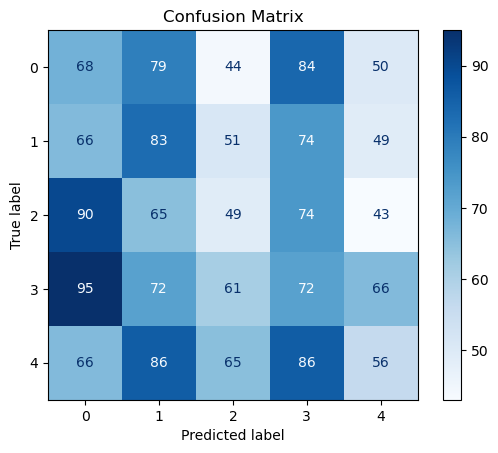

In [56]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Get predictions (returns probability for each class)
pred_probs = model.predict(test_padded)

# Convert probs to predicted class index
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = np.argmax(test_y_cat, axis=1)

# Confusion matrix
cm = confusion_matrix(true_classes, pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


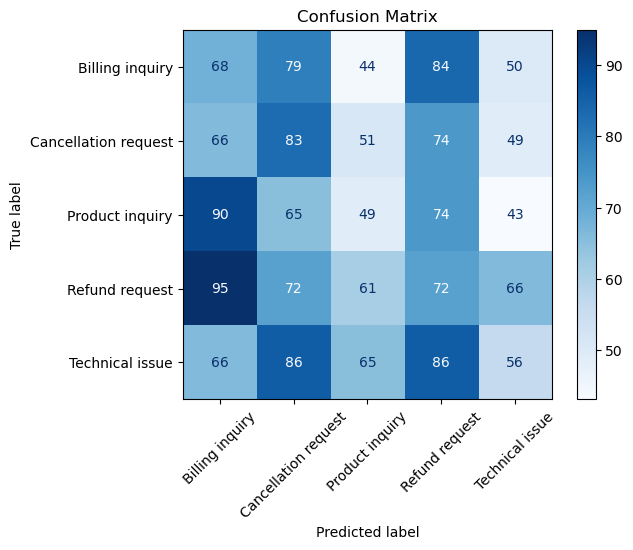

In [58]:
label_names = label_encoder.classes_  # if you're using sklearn's LabelEncoder
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()